In [ ]:
import pandas as pd

df = pd.read_csv('final_datsest_v0-1.csv', index_col=0)
df.head()

,avg_study_duration,total_study_duration,total_revisit,total_course_completion,enrolling_times,study_duration,avg_submission_rating,max_score,average_score,total_attemps,is_passed,avg_duration,avg_time_left,dominant_days,consistency_ratio,total_events
developer_id,,,,,,,,,,,,,,,,
3390,0.229354,534.394444,515,2330,63.0,26.078431,3.874348,100.0,80.739837,615.0,450.0,0 days 00:06:23.414634146,0 days 00:05:34.634146341,['Saturday'],0.166953,2330.0
5774,0.098077,132.698333,135,1353,20.0,19.578947,NaN,100.0,70.882609,460.0,253.0,0 days 00:26:57,-1 days +23:50:06.913043479,['Sunday'],0.283814,1353.0
11836,0.108893,132.304444,134,1215,51.0,31.782609,4.125000,100.0,83.109091,330.0,268.0,0 days 00:04:42.545454545,0 days 00:08:03.090909090,['Saturday'],0.241152,1215.0
17833,0.165522,285.360556,522,1724,46.0,33.128205,4.431818,100.0,87.035714,336.0,286.0,0 days 00:03:14.821428571,0 days 00:08:44.821428571,['Wednesday'],0.229698,1724.0
32258,0.130454,228.946667,541,1755,80.0,21.360656,3.602187,100.0,85.847297,740.0,613.0,0 days 00:03:33.891891891,0 days 00:07:39.324324324,['Sunday'],0.249573,1755.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import seaborn as sns

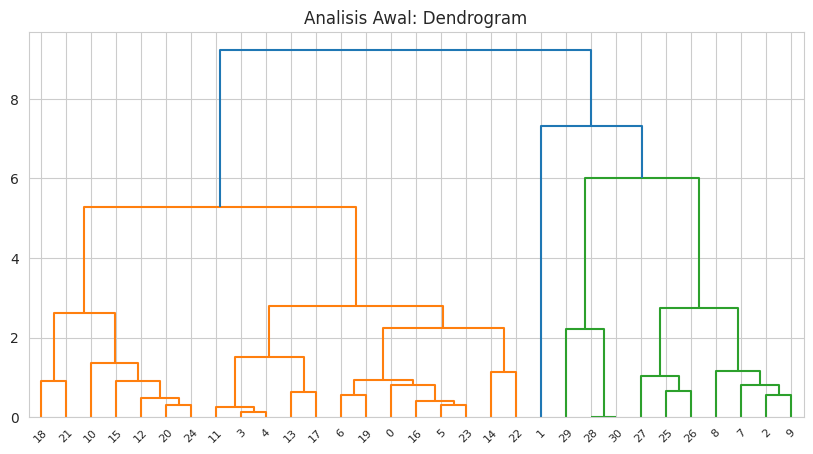

In [ ]:
# Konversi Durasi ke Menit
def convert_to_minutes(col):
    # Mengubah format timedelta ke total menit
    return pd.to_timedelta(df[col]).dt.total_seconds() / 60

df['avg_duration_minutes'] = convert_to_minutes('avg_duration')

# Buat Fitur Revisit Ratio
# (replace 0 dengan 1 di pembagi agar tidak error infinity)
df['revisit_per_completion'] = df['total_revisit'] / df['total_course_completion'].replace(0, 1)

# --- PENTING: Handle Missing Values di DataFrame Utama ---
# Agar tidak ada error saat logika if-else berjalan
df['avg_duration_minutes'] = df['avg_duration_minutes'].fillna(0)
df['total_course_completion'] = df['total_course_completion'].fillna(0)
df['revisit_per_completion'] = df['revisit_per_completion'].fillna(0)

# ==========================================
# 2. Analisis Clustering (Hanya untuk Justifikasi Laporan)
# ==========================================
# Tahap ini untuk membuktikan kenapa kita memilih threshold tertentu
features = ['total_course_completion', 'avg_duration_minutes', 'revisit_per_completion', 'consistency_ratio']
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualisasi Dendrogram (Opsional: untuk melihat struktur data)
plt.figure(figsize=(10, 5))
plt.title("Analisis Awal: Dendrogram")
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.show()

In [ ]:
# ==========================================
# 3. Rule-Based Categorization (LOGIKA FINAL ROBUST)
# ==========================================
# Pastikan handle missing values dulu (PENTING)
df['avg_duration_minutes'] = df['avg_duration_minutes'].fillna(0)
df['total_course_completion'] = df['total_course_completion'].fillna(0)
df['revisit_per_completion'] = df['revisit_per_completion'].fillna(0)

def strict_three_categories(row):
    # 1. REFLECTIVE LEARNER
    # Definisi: User yang butuh waktu lama (> 5.5 menit) ATAU sering mengulang (> 15%)
    if (row['revisit_per_completion'] > 0.15) or (row['avg_duration_minutes'] > 5.5):
        return 'Reflective Learner'

    # 2. FAST LEARNER
    # Definisi: User yang durasinya cepat (< 4.2 menit) DAN cukup produktif (> 50 materi)
    # (Threshold 4.2 dipilih agar user 'Balanced' yang agak cepat masuk ke sini)
    elif (row['avg_duration_minutes'] < 4.2) and (row['total_course_completion'] > 50):
        return 'Fast Learner'

    # 3. CONSISTENT LEARNER (Kategori Default/Sisanya)
    # Semua user yang tidak masuk kategori ekstrem (Fast/Reflective) akan masuk sini.
    # Termasuk user yang 'avg_duration' = 0 tadi.
    else:
        return 'Consistent Learner'

# Terapkan
df['learner_category'] = df.apply(strict_three_categories, axis=1)

# Cek Hasil Akhir
print("\n=== Distribusi Final ===")
print(df['learner_category'].value_counts())

print("\n=== Profil Rata-Rata ===")
# Kita tampilkan rata-rata untuk melihat karakteristik per grup
print(df.groupby('learner_category')[['total_course_completion', 'avg_duration_minutes', 'revisit_per_completion', 'consistency_ratio']].mean())

# Simpan
df.to_csv('final_dataset_3_categories.csv')


=== Distribusi Final ===
learner_category
Reflective Learner    19
Consistent Learner     6
Fast Learner           6
Name: count, dtype: int64

=== Profil Rata-Rata ===
                    total_course_completion  avg_duration_minutes  \
learner_category                                                    
Consistent Learner              1333.833333              3.266219   
Fast Learner                    2194.500000              3.410839   
Reflective Learner              1759.368421              6.078777   

                    revisit_per_completion  consistency_ratio  
learner_category                                               
Consistent Learner                0.065070           0.506859  
Fast Learner                      0.079201           0.262477  
Reflective Learner                0.216719           0.299887  


/tmp/ipython-input-3557189574.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=df, x='learner_category', y='avg_duration_minutes', order=order, palette=colors)
/tmp/ipython-input-3557189574.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=df, x='learner_category', y='consistency_ratio', order=order, palette=colors)
/tmp/ipython-input-3557189574.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], data=df, x='learner_category', y='total_course_completion', order=order, palette=colors)


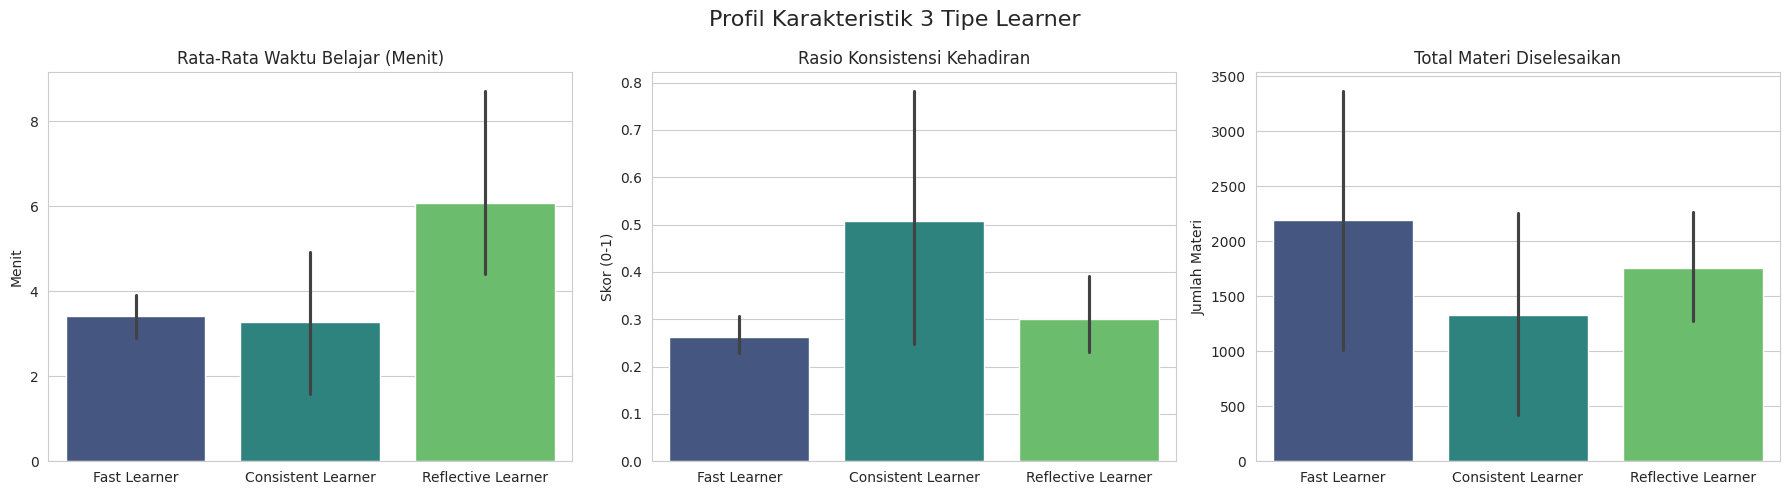

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set ukuran kanvas besar
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Profil Karakteristik 3 Tipe Learner', fontsize=16)

# Order biar rapi
order = ['Fast Learner', 'Consistent Learner', 'Reflective Learner']
colors = 'viridis'

# GRAFIK 1: DURASI (Membuktikan Reflective itu Lama)
sns.barplot(ax=axes[0], data=df, x='learner_category', y='avg_duration_minutes', order=order, palette=colors)
axes[0].set_title('Rata-Rata Waktu Belajar (Menit)')
axes[0].set_xlabel('')
axes[0].set_ylabel('Menit')

# GRAFIK 2: KONSISTENSI (Membuktikan Consistent itu Rajin)
sns.barplot(ax=axes[1], data=df, x='learner_category', y='consistency_ratio', order=order, palette=colors)
axes[1].set_title('Rasio Konsistensi Kehadiran')
axes[1].set_xlabel('')
axes[1].set_ylabel('Skor (0-1)')

# GRAFIK 3: PRODUKTIVITAS (Membuktikan Fast itu Banyak Mengerjakan)
sns.barplot(ax=axes[2], data=df, x='learner_category', y='total_course_completion', order=order, palette=colors)
axes[2].set_title('Total Materi Diselesaikan')
axes[2].set_xlabel('')
axes[2].set_ylabel('Jumlah Materi')

plt.tight_layout()
plt.show()

## **Summary**
Hasil segmentasi menunjukkan bahwa sebagian besar pengguna masuk kategori Reflective Learner (19 pengguna), sementara Consistent Learner dan Fast Learner masing-masing berjumlah 6 pengguna. Ini menandakan bahwa mayoritas user cenderung memiliki pola belajar yang lebih mendalam dan memakan waktu lebih lama per materi.

## **Perbandingan Profil Kategorisasi**

Berdasarkan empat metrik utama:

1. Durasi Rata-rata Belajar

    - Reflective Learner: ~6.08 menit

    - Fast & Consistent: ~3.2–3.4 menit
    
    -> Reflective Learner membutuhkan waktu 2× lebih lama untuk memahami materi.

2. Total Penyelesaian Materi

    - Fast Learner memiliki tingkat penyelesaian tertinggi.

    - Reflective berada di tengah.

   -> Consistent paling rendah namun tetap stabil.

3. Revisit per Completion

    - Reflective Learner punya nilai tertinggi → sering mengulang materi sebelum menyelesaikannya.

    - Fast & Consistent Learner revisiting rendah.

4. Consistency Ratio

    - Consistent Learner paling stabil dengan nilai tertinggi (~0.50).

    - Fast & Reflective lebih fluktuatif.